In [55]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [56]:
#reading data
df = pd.read_csv("VIX_Data.csv")

In [57]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-21,14.10,14.11,13.17,13.25,13.25,0
1,2014-04-22,13.13,13.26,12.90,13.19,13.19,0
2,2014-04-23,13.35,13.75,13.27,13.27,13.27,0
3,2014-04-24,13.36,14.08,13.09,13.32,13.32,0
4,2014-04-25,13.93,14.67,13.91,14.06,14.06,0


In [58]:
#dropping unwanted columns
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,Adj Close
Date,
2014-04-21,13.25
2014-04-22,13.19
2014-04-23,13.27
2014-04-24,13.32
2014-04-25,14.06
2014-04-28,13.97
2014-04-29,13.71
2014-04-30,13.41
2014-05-01,13.25


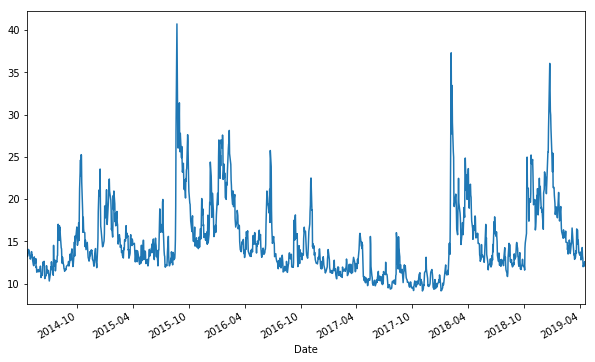

In [59]:
#plotting time series
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

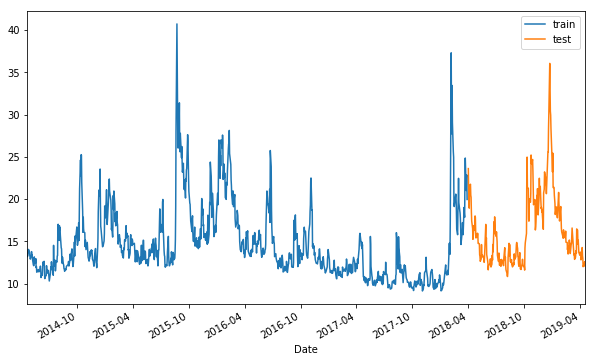

In [60]:
#dividing data into test and train
split_date = pd.Timestamp('2018-04-01')
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [61]:
#changing the data to array to fit MinMaxScaler
train = np.array(train)
test = np.array(test)

In [62]:
print(train.shape, test.shape)

(994,) (265,)


In [63]:
train = train.reshape(-1, 1)
test = test.reshape(-1,1)

In [64]:
#scaling test and train dataset to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [65]:
#retrieving training and testing data
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [66]:
#Viewing train and test data
print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])

[[-0.73987343]
 [-0.7436709 ]
 [-0.73860761]
 [-0.73544305]
 [-0.68860761]]
[[-0.0835443 ]
 [-0.24303802]
 [-0.30886087]
 [-0.37974681]
 [-0.21835448]]
[[-0.7436709 ]
 [-0.73860761]
 [-0.73544305]
 [-0.68860761]
 [-0.69430382]]
[[-0.24303802]
 [-0.30886087]
 [-0.37974681]
 [-0.21835448]
 [-0.20063296]]


## Artificial Neural Network

In [69]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/50
993/993 [==============================] - 2s 2ms/step - loss: 0.0340
Epoch 2/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0107
Epoch 3/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0101
Epoch 4/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0098
Epoch 5/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0096
Epoch 6/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0097
Epoch 7/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0096
Epoch 8/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0096
Epoch 9/50
993/993 [==============================] - 1s 1ms/step - loss: 0.0096
Epoch 00009: early stopping


### Early stopping at epoc 9 as the loss has stopped improving

In [70]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.785
The R2 score on the Test set is:	0.844


## Long Short-Term Memory (LSTM)

In [71]:
train_sc = pd.DataFrame(train_sc)
test_sc = pd.DataFrame(test_sc)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [72]:
type(train_sc)

pandas.core.frame.DataFrame

In [73]:
train_sc.shape

(994, 1)

In [76]:
#Converting train_sc and test_sc to DataFrame to fit LSTM
train_sc = pd.DataFrame(train_sc)
test_sc = pd.DataFrame(test_sc)

train_sc_df = pd.DataFrame(train_sc.values, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc.values, columns=['Y'], index=test.index)

In [77]:
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (993, 1, 1)
Test shape:  (264, 1, 1)


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [84]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
993/993 [==============================] - 4s 4ms/step - loss: 0.0786
Epoch 2/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0120
Epoch 3/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0095
Epoch 4/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0094
Epoch 5/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0094
Epoch 6/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0094
Epoch 7/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 8/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 9/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 10/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 11/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 12/100
993/993 [==============================] - 3s 3ms/step - loss: 0.0093
Epoch 13/100


## Early stopping at Epoc 87

In [85]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.853
The R2 score on the Test set is:	0.880


### Both train and test r sqaure is better than ANN

## Comparing models

In [86]:
#comparing Mean Squared Error of both the models
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

264/264 [==============================] - 1s 2ms/step
NN: 0.010993
LSTM: 0.008422


## Making predictions

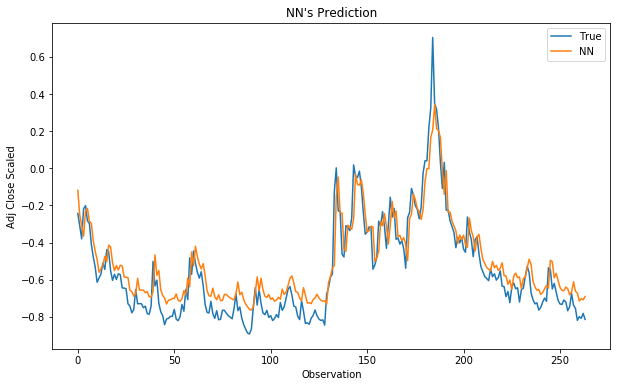

In [87]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("NN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

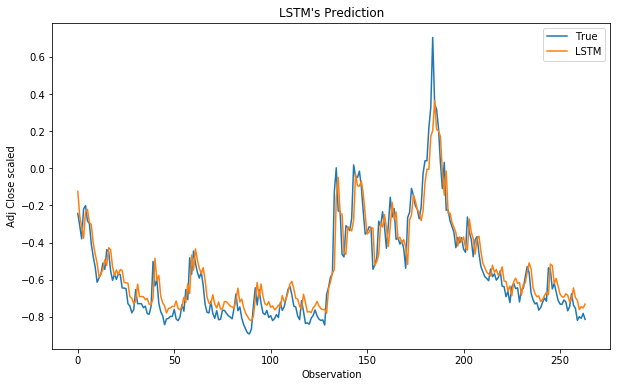

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();